In [1]:
import pandas as pd
import hddm
import numpy as np
import os

data = hddm.load_csv('data_preprocessed.csv', index_col=0)

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
data.head()

,subj_idx,response,rt,gain,loss
0,1,0,2.792,1,-1
1,1,0,1.206,1,-2
2,1,0,0.991,1,-3
3,1,0,1.256,1,-4
4,1,0,1.005,1,-5


In [3]:
m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)

Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']


In [4]:
m.find_starting_values()

/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [5]:
if not os.path.exists('savedModels/fullModel'):
    os.makedirs('savedModels/fullModel')

m.sample(5000, burn=1000, dbname='savedModels/fullModel/db_fullModel', db='pickle')

 [-----------------100%-----------------] 5001 of 5000 complete in 19346.6 sec

In [7]:
m.save('savedModels/fullModel/fullModel')

In [3]:
m = hddm.load('savedModels/fullModel/fullModel')

## Model parameters

In [30]:
m.print_stats()

                          mean         std        2.5q          25q        50q         75q       97.5q       mc err
a                       2.2124    0.044916     2.12742      2.18167    2.21205     2.24152      2.3047  0.000822393
a_std                 0.409112   0.0335985    0.347505     0.385583   0.407863    0.430244    0.482102  0.000696041
a_subj.1               2.56165     0.10493     2.36286      2.48932    2.56091     2.63215     2.77188   0.00258985
a_subj.2               2.78073    0.120563     2.55413      2.69685    2.77812      2.8587     3.02606   0.00385623
a_subj.3               2.76294    0.123963     2.53254      2.67736    2.76087      2.8452     3.01278   0.00396597
a_subj.4                2.2809    0.101207     2.10103      2.20925    2.27524     2.34573     2.48903   0.00293539
a_subj.5               1.83042   0.0799093     1.68216      1.77441    1.82773     1.88369     1.99402   0.00221839
a_subj.6               2.08893   0.0912025     1.92223      2.02547    2

$\lambda$

In [4]:
import numpy as np

In [4]:
modelParamsDF = m.nodes_db
# modelParamsDF.to_csv("fullModel_params.csv")

# group level mean of lambda
groupLevelMeanOfLambda = modelParamsDF.loc['v_loss', 'mean']/modelParamsDF.loc['v_gain', 'mean']
print("group level mean of lamdba is: ", round(groupLevelMeanOfLambda, 3))

# 95% CI for beta_G, beta_L
print("2.5% percentile for beta_L: ", round(modelParamsDF.loc['v_loss', '2.5q'], 3))
print("97.5% percentile for beta_G: ", round(modelParamsDF.loc['v_gain', '97.5q'], 3))

('group level mean of lamdba is: ', 1.573)
('2.5% percentile for beta_L: ', 0.317)
('97.5% percentile for beta_G: ', 0.239)


In [5]:
allSubjectsIndex = list(set(data['subj_idx']))
print(allSubjectsIndex)
totalNumSubjects = len(allSubjectsIndex)
print(totalNumSubjects)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94]
94


In [6]:
# how many participants have beta_L > beta_G, how many have the 95% CI greater?
# participant level mean (SD) of lambda
numLambdaMean = 0
numLambdaCI = 0
allParticipantLambdas = []

for subjectIndex in allSubjectsIndex:
    beta_gain = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    beta_L_lowerBound = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), '2.5q']
    beta_G_upperBound = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), '97.5q']
    
    if beta_loss > beta_gain:
        numLambdaMean += 1
        
    if beta_L_lowerBound > beta_G_upperBound:
        numLambdaCI += 1
        
    lambdaForThisParticipant = beta_loss/beta_gain
    allParticipantLambdas.append(lambdaForThisParticipant)

print("Number of people with beta_L > beta_G = ", numLambdaMean)
# print("Number of people with 95% CI of beta_L > beta_G = ", numLambdaCI)
print("Average lambda over all individuals = {} (SD = {})".format(round(np.mean(allParticipantLambdas), 3), round(np.std(allParticipantLambdas), 3)))

('Number of people with beta_L > beta_G = ', 84)
Average lambda over all individuals = 1.826 (SD = 0.963)


In [15]:
print("beta_L mean:", round(modelParamsDF.loc['v_loss', 'mean'], 3))
print("beta_L median", round(modelParamsDF.loc['v_loss', '50q'], 3))
print("beta_L 2.5q:", round(modelParamsDF.loc['v_loss', '2.5q'], 3))
print("beta_L 97.5q:", round(modelParamsDF.loc['v_loss', '97.5q'], 3))
print("beta_L SD", round(modelParamsDF.loc['v_loss', 'std'], 3))
print("\n")
print("beta_G mean:", round(modelParamsDF.loc['v_gain', 'mean'], 3))
print("beta_G median", round(modelParamsDF.loc['v_gain', '50q'], 3))
print("beta_G 2.5q:", round(modelParamsDF.loc['v_gain', '2.5q'], 3))
print("beta_G 97.5q:", round(modelParamsDF.loc['v_gain', '97.5q'], 3))
print("beta_G SD", round(modelParamsDF.loc['v_gain', 'std'], 3))

('beta_L mean:', 0.342)
('beta_L median', 0.342)
('beta_L 2.5q:', 0.317)
('beta_L 97.5q:', 0.366)
('beta_L SD', 0.012)


('beta_G mean:', 0.217)
('beta_G median', 0.217)
('beta_G 2.5q:', 0.196)
('beta_G 97.5q:', 0.239)
('beta_G SD', 0.011)


$\gamma$

In [8]:
# 95 CI interval
Z_CI_lowerBound = (modelParamsDF.loc['z'.format(subjectIndex), '2.5q'] - 0.5)*2
Z_CI_upperBound = (modelParamsDF.loc['z'.format(subjectIndex), '97.5q'] - 0.5)*2
print("confidence interval of gamma: ", round(Z_CI_lowerBound, 3), round(Z_CI_upperBound, 3))

('confidence interval of gamma: ', -0.104, -0.047)


In [9]:
# mean gamma across all participants, how many participants have 95% CI of gamma strictly negative
allParticipantsZ = []
countGammaMean = 0
countGammaCI = 0

for participantIndex in allSubjectsIndex:
    a_participant = modelParamsDF.loc['a_subj.{}'.format(participantIndex), 'mean']
    z_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), 'mean'] - 0.5)*2
    allParticipantsZ.append(z_participant)
    z_upperBound_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), '97.5q'] - 0.5)*2
    
    if z_upperBound_participant < 0:
        countGammaCI += 1
        
    if z_participant < 0:
        countGammaMean += 1
    
mean_Z = np.mean(allParticipantsZ)
SD_Z = np.std(allParticipantsZ)
print("Mean value of pre-valuation bias across all participants: {} (SD = {})".format(round(mean_Z, 3), round(SD_Z, 3)))
print("Number of participants with negative gamma: ", round(countGammaMean, 3))
print("Number of participants with 95% CI of gamma negative: ", round(countGammaCI, 3))

Mean value of pre-valuation bias across all participants: -0.073 (SD = 0.133)
('Number of participants with negative gamma: ', 68.0)
('Number of participants with 95% CI of gamma negative: ', 35.0)


In [16]:
print("gamma mean:", round((modelParamsDF.loc['z', 'mean'] - 0.5)*2, 3))
print("gamma median", round((modelParamsDF.loc['z', '50q'] - 0.5)*2, 3))
print("gamma 2.5q:", round((modelParamsDF.loc['z', '2.5q'] - 0.5)*2, 3))
print("gamma 97.5q:", round((modelParamsDF.loc['z', '97.5q'] - 0.5)*2, 3))
print("gamma SD", round((modelParamsDF.loc['z', 'std'])*2, 3))

('gamma mean:', -0.075)
('gamma median', -0.075)
('gamma 2.5q:', -0.104)
('gamma 97.5q:', -0.047)
('gamma SD', 0.015)


$\alpha$

In [19]:
# group-level mean
print("Group-level mean of alpha is: ", modelParamsDF.loc['v_Intercept'.format(subjectIndex), 'mean'])

# how many participants have mean and 95% CI negative?
allParticipantsAlphas = []
countAlphaMean = 0
countAlphaCI = 0

for participantIndex in allSubjectsIndex:
    alpha_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean']
    allParticipantsAlphas.append(alpha_participant)
    alpha_upperBound_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), '97.5q']
    
    if alpha_upperBound_participant < 0:
        countAlphaCI += 1
        
    if alpha_participant < 0:
        countAlphaMean += 1
        
mean_alpha = np.mean(allParticipantsAlphas)
SD_alpha = np.std(allParticipantsAlphas)
print("Mean value of fixed utility bias across all participants: {} ({})".format(round(mean_alpha, 3), round(SD_alpha, 3)))
print("Number of participants with negative alpha: ", round(countAlphaMean, 3))
print("Number of participants with 95% CI of alpha negative: ", round(countAlphaCI, 3))

('Group-level mean of alpha is: ', 0.06262878885116399)
Mean value of fixed utility bias across all participants: 0.062 (0.641)
('Number of participants with negative alpha: ', 46.0)
('Number of participants with 95% CI of alpha negative: ', 18.0)


In [20]:
print("alpha mean:", round(modelParamsDF.loc['v_Intercept', 'mean'], 3))
print("alpha median", round(modelParamsDF.loc['v_Intercept', '50q'], 3))
print("alpha 2.5q:", round(modelParamsDF.loc['v_Intercept', '2.5q'], 3))
print("alpha 97.5q:", round(modelParamsDF.loc['v_Intercept', '97.5q'], 3))
print("alpha SD", round(modelParamsDF.loc['v_Intercept', 'std'], 3))

('alpha mean:', 0.063)
('alpha median', 0.064)
('alpha 2.5q:', -0.093)
('alpha 97.5q:', 0.22)
('alpha SD', 0.08)


$\theta$

In [13]:
print("theta mean:", round(modelParamsDF.loc['a', 'mean']/2, 3))
print("theta 2.5q:", round(modelParamsDF.loc['a', '2.5q']/2, 3))
print("theta 97.5q:", round(modelParamsDF.loc['a', '97.5q']/2, 3))
print("theta median", round(modelParamsDF.loc['a', '50q']/2, 3))
print("theta SD", round(modelParamsDF.loc['a', 'std']/2, 3))

('theta mean:', 1.106)
('theta 2.5q:', 1.064)
('theta 97.5q:', 1.152)
('theta median', 1.106)
('theta SD', 0.022)


$\tau$

In [14]:
print("tau mean:", round(modelParamsDF.loc['t', 'mean'], 3))
print("tau 2.5q:", round(modelParamsDF.loc['t', '2.5q'], 3))
print("tau 97.5q:", round(modelParamsDF.loc['t', '97.5q'], 3))
print("tau median", round(modelParamsDF.loc['t', '50q'], 3))
print("tau SD", round(modelParamsDF.loc['t', 'std'], 3))

('tau mean:', 0.647)
('tau 2.5q:', 0.619)
('tau 97.5q:', 0.675)
('tau median', 0.647)
('tau SD', 0.014)


# Correlation with rejection rates

In [22]:
def getPAcceptFromSubjectIndex(subjectIndex):
    subjectResponses = np.array(data.loc[data['subj_idx'] == subjectIndex]['response'])
    return np.mean(subjectResponses)

allParticipants_p_accept = np.array([getPAcceptFromSubjectIndex(subjectIndex) for subjectIndex in allSubjectsIndex])
allParticipants_p_accept

array([0.295, 0.515, 0.455, 0.425, 0.415, 0.165, 0.345, 0.255, 0.355,
       0.415, 0.385, 0.27 , 0.24 , 0.09 , 0.545, 0.16 , 0.195, 0.215,
       0.355, 0.295, 0.21 , 0.135, 0.435, 0.565, 0.645, 0.585, 0.185,
       0.16 , 0.395, 0.15 , 0.12 , 0.515, 0.095, 0.26 , 0.215, 0.405,
       0.4  , 0.68 , 0.185, 0.065, 0.435, 0.43 , 0.365, 0.165, 0.21 ,
       0.23 , 0.525, 0.535, 0.46 , 0.35 , 0.295, 0.37 , 0.195, 0.15 ,
       0.24 , 0.225, 0.43 , 0.195, 0.06 , 0.245, 0.315, 0.38 , 0.04 ,
       0.51 , 0.44 , 0.125, 0.395, 0.345, 0.225, 0.095, 0.085, 0.15 ,
       0.24 , 0.075, 0.55 , 0.155, 0.405, 0.105, 0.265, 0.34 , 0.335,
       0.215, 0.36 , 0.145, 0.455, 0.365, 0.385, 0.42 , 0.32 , 0.385,
       0.13 , 0.385, 0.675, 0.775])

In [23]:
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

In [24]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

('Pearson correlation between Lambda and P(Acceptance) is: ', (-0.3322146121937505, 0.0010706225374500144))


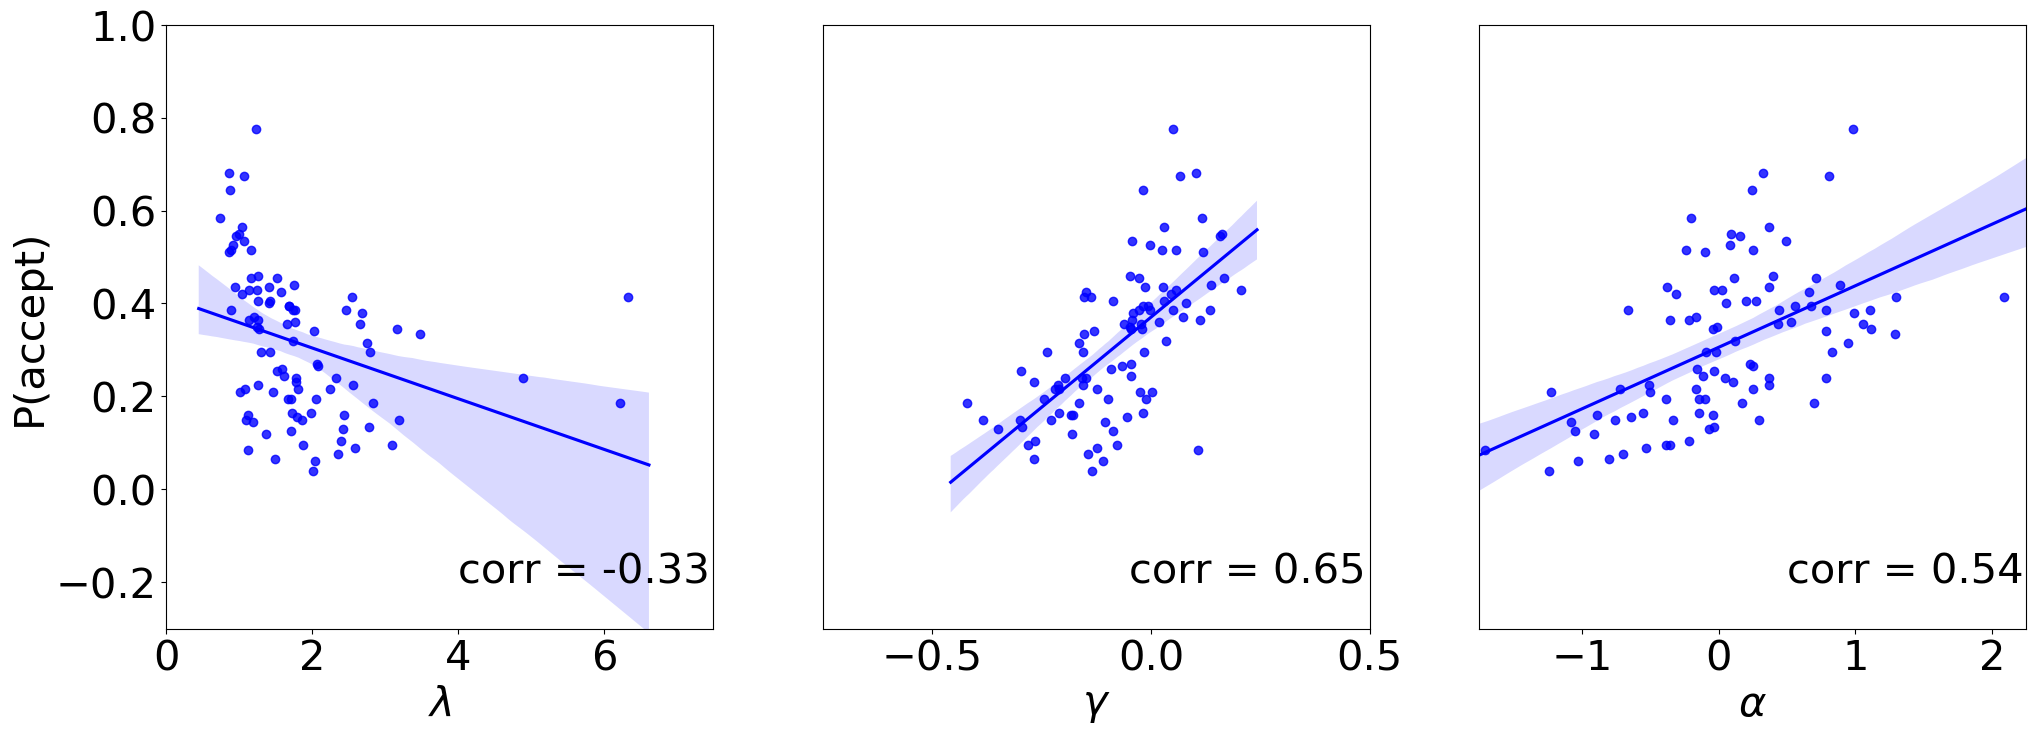

In [26]:
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), colspan=1)
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue', ax=ax1)
ax1.set_xlabel(r"$\lambda$")
ax1.set_ylabel("P(accept)")
ax1.annotate("corr = {}".format(round(pearsonr(allParticipantLambdas, allParticipants_p_accept)[0], 2)), (4, -0.2))
ax1.set_xlim(0, 7.5)
ax1.set_ylim(-0.3, 1)

ax2 = plt.subplot2grid(shape=(1,3), loc=(0,1), colspan=1)
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue', ax=ax2)
ax2.set_xlabel(r"$\gamma$")
ax2.set_xlim(-0.75, 0.5)
ax2.set_ylim(-0.3, 1)
ax2.annotate("corr = {}".format(round(pearsonr(allParticipantsZ, allParticipants_p_accept)[0], 2)), (-0.05, -0.2))
# ax2.tick_params(axis='y', left=False)
ax2.set_yticks([])


ax3 = plt.subplot2grid(shape=(1,3), loc=(0,2), colspan=1)
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue', ax=ax3)
ax3.set_xlabel(r"$\alpha$")
ax3.set_xlim(-1.75, 2.25)
ax3.set_ylim(-0.3, 1)
ax3.annotate("corr = {}".format(round(pearsonr(allParticipantsAlphas, allParticipants_p_accept)[0], 2)), (0.5, -0.2))
ax3.set_yticks([])

print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))
plt.savefig("fig/pAccept_corr.png", bbox_inches='tight')

('Pearson correlation between Lambda and P(Acceptance) is: ', (-0.3322146121937505, 0.0010706225374500144))


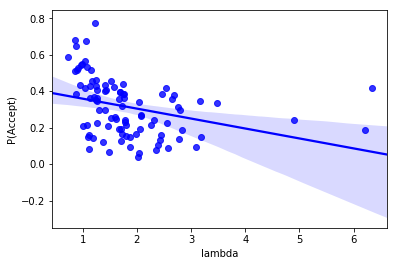

In [16]:
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue')
plt.xlabel("lambda")
plt.ylabel("P(Accept)")
print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))

('Pearson correlation between gamma and P(Acceptance) is: ', (0.6515673377506597, 1.1469573169243393e-12))


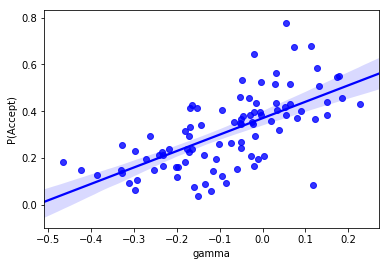

In [17]:
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue')
plt.xlabel("gamma")
plt.ylabel("P(Accept)")
print("Pearson correlation between gamma and P(Acceptance) is: ", pearsonr(allParticipantsZ, allParticipants_p_accept))

('Pearson correlation between alpha and P(Acceptance) is: ', (0.5371014659283793, 2.391826793257592e-08))


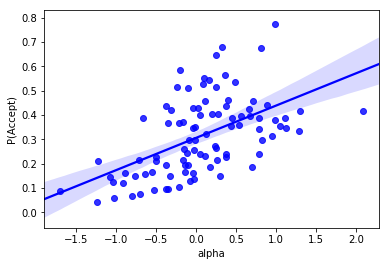

In [18]:
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue')
plt.xlabel("alpha")
plt.ylabel("P(Accept)")
print("Pearson correlation between alpha and P(Acceptance) is: ", pearsonr(allParticipantsAlphas, allParticipants_p_accept))

# Correlation with lambda (traditional method -- computed using logistic regression)

In [19]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

In [27]:
from sklearn.linear_model import LogisticRegression
allSubjectsIndex = np.array(allSubjectsIndex)
indicesToAnalyze = allSubjectsIndex[allParticipants_p_accept[:] != 0]

def computeParticipantLambdaLR(subjectIndex):
    participantData = data[data['subj_idx'] == subjectIndex]
    X = participantData[['gain', 'loss']]
    y = participantData['response']
    classifier = LogisticRegression(fit_intercept=True).fit(X, y)
    coefficients = classifier.coef_
    participantLambdaLR = coefficients[0][1]/coefficients[0][0]
    return participantLambdaLR

allParticipantLambdasLR = [computeParticipantLambdaLR(_) for _ in indicesToAnalyze]

/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


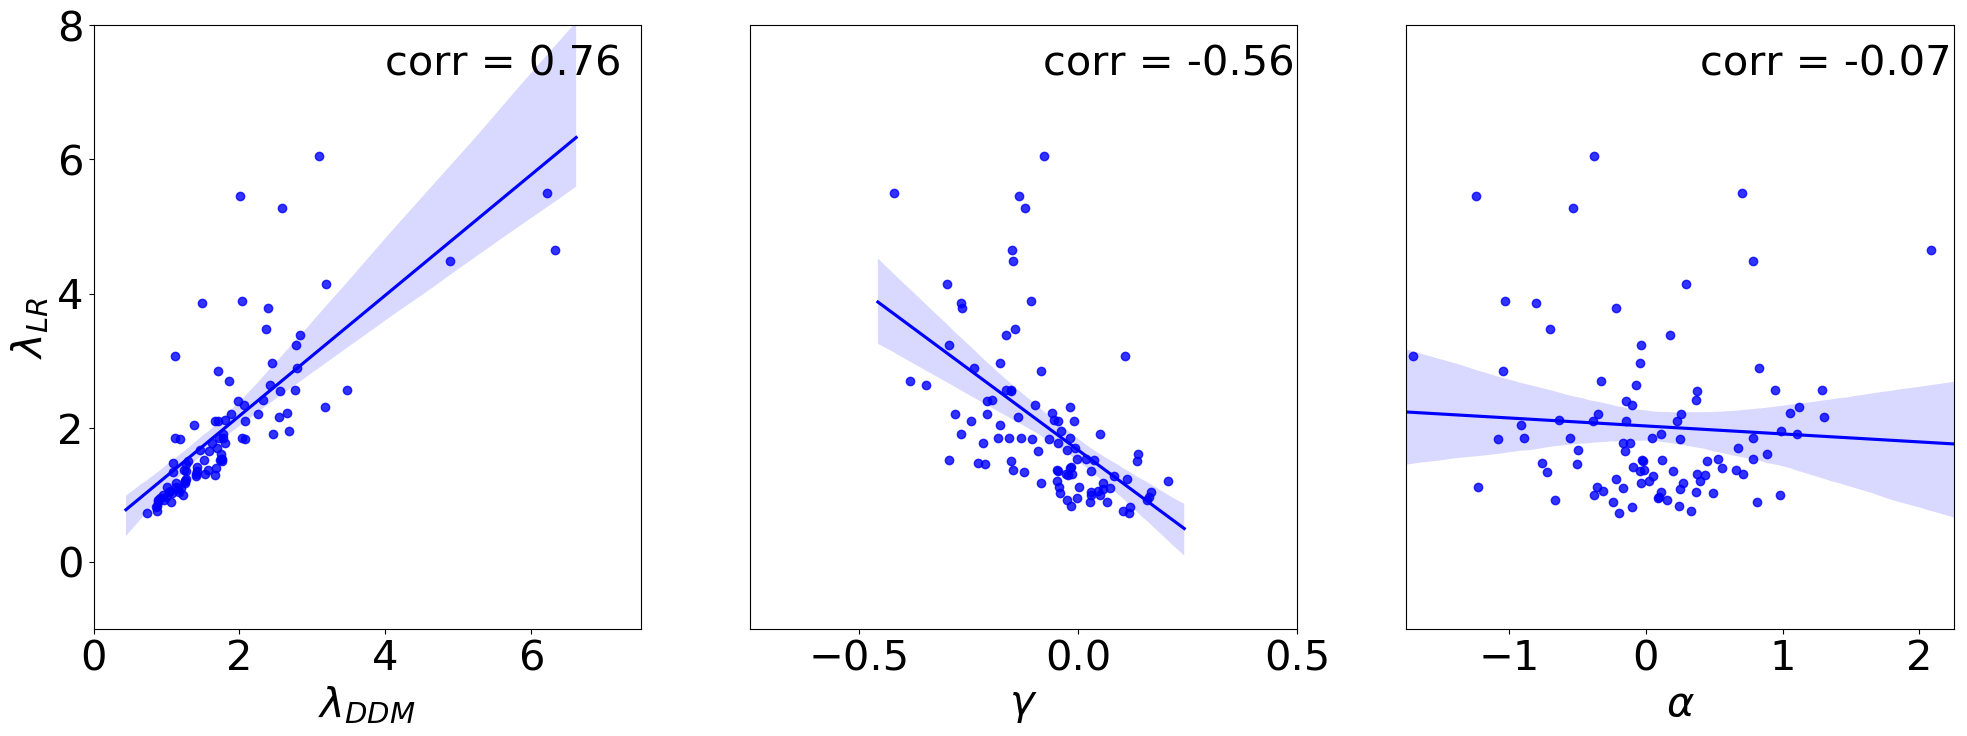

In [31]:
fig=plt.figure(figsize=(24,8), dpi= 100, facecolor='w', edgecolor='k')

ax1 = plt.subplot2grid(shape=(1,3), loc=(0,0), colspan=1)
sns.regplot(allParticipantLambdas, allParticipantLambdasLR, color ='blue', ax=ax1)
ax1.set_xlabel(r"$\lambda_{DDM}$")
ax1.set_ylabel(r"$\lambda_{LR}$")
ax1.annotate("corr = {}".format(round(pearsonr(allParticipantLambdas, allParticipantLambdasLR)[0], 2)), (4, 7.25))
ax1.set_xlim(0, 7.5)
ax1.set_ylim(-1, 8)

ax2 = plt.subplot2grid(shape=(1,3), loc=(0,1), colspan=1)
sns.regplot(allParticipantsZ, allParticipantLambdasLR, color ='blue', ax=ax2)
ax2.set_xlabel(r"$\gamma$")
ax2.set_xlim(-0.75, 0.5)
ax2.set_ylim(-1, 8)
ax2.annotate("corr = {}".format(round(pearsonr(allParticipantsZ, allParticipantLambdasLR)[0], 2)), (-0.08, 7.25))
# ax2.tick_params(axis='y', left=False)
ax2.set_yticks([])


ax3 = plt.subplot2grid(shape=(1,3), loc=(0,2), colspan=1)
sns.regplot(allParticipantsAlphas, allParticipantLambdasLR, color ='blue', ax=ax3)
ax3.set_xlabel(r"$\alpha$")
ax3.set_xlim(-1.75, 2.25)
ax3.set_ylim(-1, 8)
ax3.annotate("corr = {}".format(round(pearsonr(allParticipantsAlphas, allParticipantLambdasLR)[0], 2)), (0.4, 7.25))
ax3.set_yticks([])

plt.savefig("fig/lambda_LR_corr.png", bbox_inches='tight')

In [21]:
print("Lambda computed using logistic regression, mean: {}, SD: {}".format(np.mean(allParticipantLambdasLR), np.std(allParticipantLambdasLR)))

Lambda computed using logistic regression, mean: 2.02000787856, SD: 1.14580801643


(array([ 0., 10., 28., 21., 13.,  8.,  4.,  3.,  2.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 9 Patch objects>)

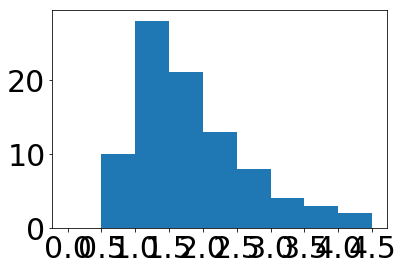

In [22]:
from matplotlib import pyplot as plt
plt.xticks(np.arange(0, 5, 0.5))
plt.hist(allParticipantLambdasLR, np.arange(0, 5, 0.5))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.6663481849438241, 2.3029362616428074e-13))


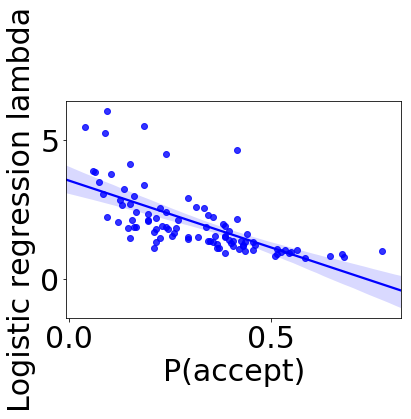

In [23]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# pAcceptToCorrelate = np.array(allParticipants_p_accept)[indicesToAnalyze]
sns.regplot(allParticipants_p_accept, allParticipantLambdasLR, color ='blue')
plt.xlabel("P(accept)")
plt.ylabel("Logistic regression lambda")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(allParticipants_p_accept, allParticipantLambdasLR))

('Pearson correlation between DDM lambda and Logistic regression lambda is: ', (0.7555619481700953, 1.3680343110776359e-18))


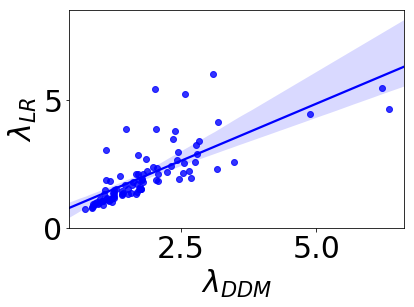

In [24]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
sns.regplot(allParticipantLambdas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\lambda_{DDM}$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between DDM lambda and Logistic regression lambda is: ", pearsonr(allParticipantLambdas, allParticipantLambdasLR))

('Pearson correlation between gamma and Logistic regression lambda is: ', (-0.5586357870312658, 4.8865238610451175e-09))


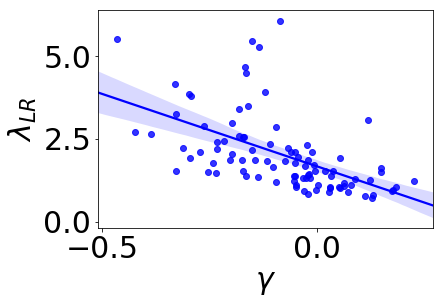

In [25]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
sns.regplot(allParticipantsZ, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between gamma and Logistic regression lambda is: ", pearsonr(allParticipantsZ, allParticipantLambdasLR))

('Pearson correlation between alpha and Logistic regression lambda is: ', (-0.0665145508896235, 0.5241509295766154))


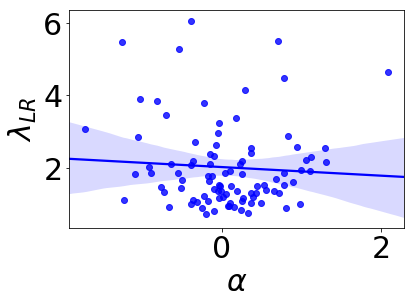

In [29]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
sns.regplot(allParticipantsAlphas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between alpha and Logistic regression lambda is: ", pearsonr(allParticipantsAlphas, allParticipantLambdasLR))

In [27]:
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore
import pandas as pd

y = np.reshape(allParticipantLambdasLR, (-1, 1))
X = np.vstack((allParticipantLambdas, allParticipantsZ, allParticipantsAlphas)).T
# X = np.vstack((allParticipantLambdas, allParticipantsZ, allParticipantsAlphas)).T

combined = np.hstack((y, zscore(X)))
df = pd.DataFrame(combined)
df.columns = ['y', 'x1', 'x2', 'x3']
df_z = df.select_dtypes(include=[np.number]).dropna()#.apply(stats.zscore)


formula = 'y ~ x1 + x2 + x3'
result = smf.ols(formula, data=df_z).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     115.8
Date:                Thu, 31 Dec 2020   Prob (F-statistic):           8.51e-31
Time:                        00:21:47   Log-Likelihood:                -71.853
No. Observations:                  94   AIC:                             151.7
Df Residuals:                      90   BIC:                             161.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.0200      0.055     36.876      0.000       1.911       2.129
x1             1.1092      0.076     14.511      0.000       0.957       1.261
x2            -0.0590      0.068     -0.869      0.387      -0.194       0.076
x3            -0.5871      0.067     -8.795      0.000      -0.720      -0.455
==============================================================================
Omnibus:                       48.751   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.477
Skew:                           1.748   Prob(JB):                     1.92e-36
Kurtosis:                       8.456   Cond. No.                         2.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Simulate data

In [32]:
ppc_data = hddm.utils.post_pred_gen(m, samples=20, progress_bar=True)

 [-----------------103%------------------] 97 of 94 complete in 10276.6 sec

In [45]:
def extractStakesFromParticipantIndex(participantIndex):
    participantData = np.asarray(data[data['subj_idx'] == participantIndex])
    participantStakes = participantData[:, 3:]
    return participantStakes

def extractTrialsFromParticipantIndex(participantIndex):
    participantData = np.asarray(data[data['subj_idx'] == participantIndex])
    participantTrials = participantData[:, 1]
    return participantStakes

In [48]:
import numpy as np
overallData = np.zeros((1, 5))

for (node, sample), sim_data in ppc_data.groupby(level=(0, 1)):
    print("-------")
    print("node: ", node)
    sim_data_array = np.asarray(sim_data)
    numTrials = np.shape(sim_data_array)[0]
    print("number of trials: ", numTrials)
    participantIndex = int(filter(str.isdigit, node))
    participantStakes = extractStakesFromParticipantIndex(participantIndex)
    participantIndexArray = np.full((numTrials, 1), participantIndex)
    responsesArray = np.zeros((numTrials, 1))
    responsesArray[sim_data_array[:, 0] > 0] = 1
    reactionTimesArray = np.abs(sim_data_array)
    sim_data_modified = np.hstack((participantIndexArray, responsesArray, reactionTimesArray, participantStakes))
    overallData = np.vstack((overallData, sim_data_modified))
    
print(np.shape(overallData))

-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('number of trials: ', 200)
-------
('node: ', 'wfpt.1')
('

-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.17')
('number of trials: ', 200)
-------
('node: ', 'wfpt.18')
('number of trials: ', 200)
-------
('node: ', 'wfpt.18')
('number of trials: ', 200)
-------
('node: ', 'wfpt.18')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.24')
('number of trials: ', 200)
-------
('node: ', 'wfpt.25')
('number of trials: ', 200)
-------
('node: ', 'wfpt.25')
('number of trials: ', 200)
-------
('node: ', 'wfpt.25')
('number of trials: ', 200)
-------
('node: ', 'wfpt.25')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.30')
('number of trials: ', 200)
-------
('node: ', 'wfpt.30')
('number of trials: ', 200)
-------
('node: ', 'wfpt.30')
('number of trials: ', 200)
-------
('node: ', 'wfpt.30')
('number of trials: ', 200)
-------
('node: ', 'wfpt.30')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node: ', 'wfpt.31')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.38')
('number of trials: ', 200)
-------
('node: ', 'wfpt.38')
('number of trials: ', 200)
-------
('node: ', 'wfpt.38')
('number of trials: ', 200)
-------
('node: ', 'wfpt.38')
('number of trials: ', 200)
-------
('node: ', 'wfpt.38')
('number of trials: ', 200)
-------
('node: ', 'wfpt.38')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node: ', 'wfpt.39')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node: ', 'wfpt.45')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.51')
('number of trials: ', 200)
-------
('node: ', 'wfpt.52')
('number of trials: ', 200)
-------
('node: ', 'wfpt.52')
('number of trials: ', 200)
-------
('node: ', 'wfpt.52')
('number of trials: ', 200)
-------
('node: ', 'wfpt.52')
('number of trials: ', 200)
-------
('node: ', 'wfpt.52')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.58')
('number of trials: ', 200)
-------
('node: ', 'wfpt.58')
('number of trials: ', 200)
-------
('node: ', 'wfpt.58')
('number of trials: ', 200)
-------
('node: ', 'wfpt.58')
('number of trials: ', 200)
-------
('node: ', 'wfpt.58')
('number of trials: ', 200)
-------
('node: ', 'wfpt.58')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node: ', 'wfpt.59')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.64')
('number of trials: ', 200)
-------
('node: ', 'wfpt.64')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node: ', 'wfpt.65')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node: ', 'wfpt.71')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.78')
('number of trials: ', 200)
-------
('node: ', 'wfpt.79')
('number of trials: ', 200)
-------
('node: ', 'wfpt.79')
('number of trials: ', 200)
-------
('node: ', 'wfpt.79')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node: ', 'wfpt.85')
('number of trials: ', 200)
-------
('node

-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.91')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node: ', 'wfpt.92')
('number of trials: ', 200)
-------
('node

In [50]:
overallData = overallData[1:, :]

In [51]:
if not os.path.exists('simulatedData'):
    os.makedirs('simulatedData')

np.savetxt("simulatedData/fullModel.csv", overallData, delimiter=",", fmt='%.5f')